<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/Nancy_notebook/BaselineModel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/MMAI_valid/  

/content/drive/MyDrive/MMAI_valid


In [ ]:
%cd /content/drive/MyDrive/MMAI_Train/  

/content/drive/MyDrive/MMAI_Train


In [ ]:
!unzip '/content/drive/MyDrive/MMAI_Train/train.zip' -d '/content/drive/MyDrive/MMAI_Train'
!unzip '/content/drive/MyDrive/MMAR_valid/valid.zip' -d '/content/drive/MyDrive/MMAI_valid'

In [ ]:
!unzip '/content/drive/MyDrive/MMAI_valid/valid.zip' -d '/content/drive/MyDrive/MMAI_valid'

In [71]:
!pwd

/content


### **Vision-Transformaers for Classifciation Model**

In [16]:
import os
import cv2
import glob
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


modules loaded


In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/MMAI_Train/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('/content/drive/MyDrive/MMAI_valid/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 25851 images belonging to 11 classes.
Found 6684 images belonging to 11 classes.


In [10]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # valid and test dataframe
    files, classes = define_paths(tr_dir)
    dummy_df = define_df(files, classes)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df


In [12]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

Found 25850 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 15510 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 10340 validated image filenames belonging to 11 classes.


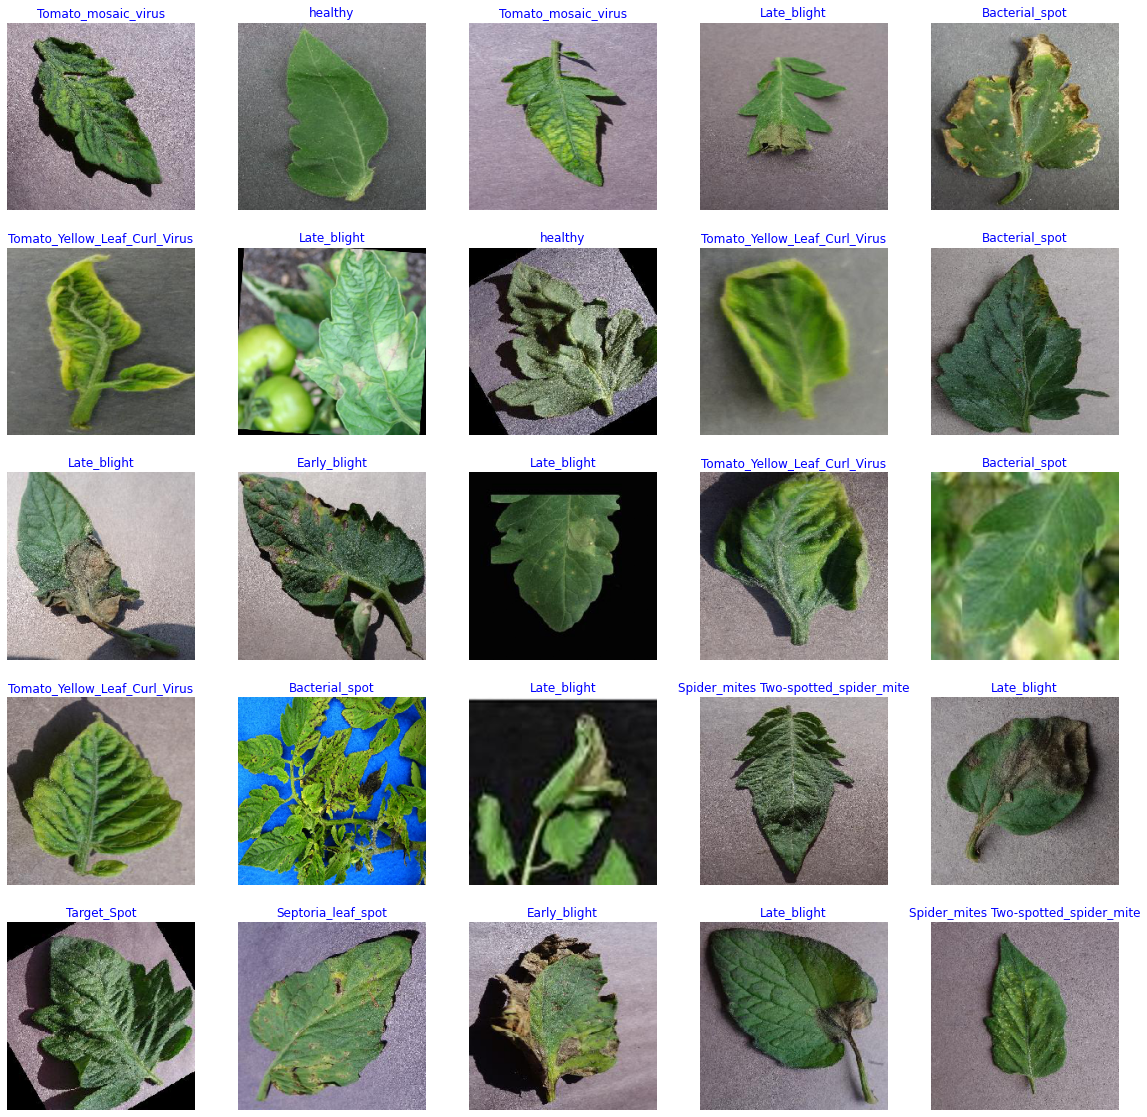

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [61]:

# Path to the directory containing the classes
path_to_dir_train = "/content/drive/MyDrive/MMAI_Train/"
path_to_dir_valid = "/content/drive/MyDrive/MMAI_valid/"

train_df, valid_df, test_df = create_df(path_to_dir_train, path_to_dir_valid )

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

# Get the list of classes
classes1 = os.listdir(path_to_dir_train)
classes2 = os.listdir(path_to_dir_valid)

# Print the classes
print(classes1)
print(classes2)

In [14]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [18]:
# check image size
sample_df = train_df.sample(n=300, replace=False)
image_size_dict = dict()
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
      img = cv2.imread(fpath)
      h_w = (img.shape[0], img.shape[1])
      image_size_dict[h_w] = image_size_dict.get(h_w, 0) + 1
    except:
        pass

{ k: v for k,v in image_size_dict.items() if v > 10}

{(256, 256): 219, (640, 640): 14, (227, 227): 50}

In [64]:
#--------
# approach 1 - ImageDataGenerator
#--------
IMAGE_SIZE = 224 
BATCH_SIZE = 32
CLASS_MODE = 'categorical'  # one-hot encoded

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True,
                                   shear_range=0.2,
                                  # zoom_range=0.2,
                                  # rotation_range=10,
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255)

train_ds = train_datagen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', color_mode= 'rgb', shuffle= True, class_mode= CLASS_MODE, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size= BATCH_SIZE, seed = 24)
valid_ds = test_datagen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', color_mode= 'rgb', shuffle= True, class_mode= CLASS_MODE, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size= BATCH_SIZE, seed = 23)
test_ds = test_datagen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', color_mode= 'rgb', shuffle= True, class_mode= CLASS_MODE, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size= BATCH_SIZE, seed = 24)


Found 25850 validated image filenames belonging to 11 classes.
Found 15510 validated image filenames belonging to 11 classes.
Found 10340 validated image filenames belonging to 11 classes.


In [68]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [74]:

from pathlib import Path
import imghdr

data_dir = '/content/drive/MyDrive/MMAI_Train/'
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png", 'jpg']
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/drive/MyDrive/MMAI_Train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg is not an image
/content/drive/MyDrive/MMAI_Train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/drive/MyDrive/MMAI_Train/Early_blight/EB_(976).jpg is not an image


KeyboardInterrupt: ignored

# **CNN Model**

In [75]:
# Define the hyperparameters
batch_size = 32
num_epochs = 10
image_size = (224,224)

In [80]:


# Define the CNN model architecture

num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation="softmax"),
])
    

In [ ]:

# Compile the model with an optimizer, a loss function, and a metric

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=100
)